Author: Dan Shea  
Date: 2019.09.24  
#### Examining the correlation between TEs and Recombination loci
We want to examine if there is any correlation (or anti-correlation) between the presence of _transposable elements_ (TEs) and meiotic recombination events. To examine this, we will utilize the same sliding window size and count the number of TEs within a given window. Pairing the number of meiotic recombination events and the number of TEs for a common window we may compute the Pearson correlation between the two. A cursory examination of class I TEs (i.e. - retrotransposons) appears to suggest that there is a negative correlation bewteen class I TE density and the number of recombination events (i.e. - The higher the density of class I TEs, the fewer the number of recombination events in that region).

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from statsmodels.stats import multitest
import os
import os.path
import urllib.parse
from collections import OrderedDict
import plotly.express as px

In [2]:
samples = ['N01','N03','N04','N05','N06','N07','N08','N09','N10','N11',
           'N12','N13','N14','N16','N17','N18','N19','N20','N21','N22',]
founders = ['KASALATH','KEIBOBA','SHONI','TUPA_121-3','SURJAMUKHI','RATUL','BADARI_DHAN','KALUHEENATI','JAGUARY','REXMONT',
            'URASAN','TUPA_729','DEE_JIAO_HUA_LUO','NERICA_1','TAKANARI','C8005','MOUKOTOU','NORTAI','SESIA','HAYAYUKI',]
datadirs = ['_'.join([x, y]) for x, y in zip(samples, founders)]

In [3]:
genome_size = OrderedDict({'chr01': 43270923,
                           'chr02': 35937250,
                           'chr03': 36413819,
                           'chr04': 35502694,
                           'chr05': 29958434,
                           'chr06': 31248787,
                           'chr07': 29697621,
                           'chr08': 28443022,
                           'chr09': 23012720,
                           'chr10': 23207287,
                           'chr11': 29021106,
                           'chr12': 27531856,})

In [4]:
recombination_frequencies = OrderedDict()
for key, fkey in zip(samples, founders):
    recombination_frequencies[key] = pd.read_csv('recombination_frequency/{}_{}_recombination_frequency.tsv'.format(key, fkey), sep='\t', index_col=None)

In [5]:
# Checking the loaded dataframes for 100 kbp sliding window analysis of recombination events
recombination_frequencies['N01'][0:10]

,CHROM,Window,Start,Stop,Count,N,Frequency
0,chr01,0,0,100000,0,171,0.000000
1,chr01,1,100000,200000,0,171,0.000000
2,chr01,2,200000,300000,7,171,0.040936
3,chr01,3,300000,400000,0,171,0.000000
4,chr01,4,400000,500000,6,171,0.035088
5,chr01,5,500000,600000,2,171,0.011696
6,chr01,6,600000,700000,2,171,0.011696
7,chr01,7,700000,800000,1,171,0.005848
8,chr01,8,800000,900000,1,171,0.005848
9,chr01,9,900000,1000000,2,171,0.011696


In [6]:
# Checking how to use urllib.parse.unquote to un-escape the Note field of the gff3
urllib.parse.unquote('retrotransposon%20protein%2C%20putative%2C%20Ty3-gypsy%20subclass')

'retrotransposon protein, putative, Ty3-gypsy subclass'

In [7]:
TEs = pd.read_csv('/dsu1/Research/NAM2017/reference_genome/MSU_O_sativa_v7.0_all.sorted.TE.tsv', sep='\t', index_col=None, header=None, 
                  names=['CHROM', 'source', 'gff_type', 'Start', 'Stop', 'score', 'strand', 'phase', 'attributes'])

In [8]:
# First, we'll test out our dictionary comprehension
#
#### WHAT IT DOES ####
#
# We want to unquote the attribute string to un-escape characters
# Then, we split it up based on the ';' delimiter
# We iterate over every element in the list returned by split
# We call split on those elements, using '=' as our delimiter
# For each list created by split, we construct a dictionary key/value pair
# reuturning an anonymous dict of the ID, Name, and Note fields of the attribute string

{key: value for key, value in [x.split('=') for x in urllib.parse.unquote(TEs.iloc[0].attributes).split(';')]}

{'ID': 'LOC_Os01g01090',
 'Name': 'LOC_Os01g01090',
 'Note': 'retrotransposon protein, putative, unclassified, expressed'}

In [9]:
# Now, we apply the comprehension to the attributes of the TEs dataframe
# This is done by passing it as a lambda function to the apply method of the attributes series within the TEs dataframe
# It returns a list of the Note values, which we then set as the attributes column in the dataframe

TEs['attributes'] = [d['Note'] for d in TEs.attributes.apply(lambda r: {key: value for key, value in [x.split('=') for x in urllib.parse.unquote(r).split(';')]})]

In [10]:
# Let's examine the results of running our function
TEs[0:10]

,CHROM,source,gff_type,Start,Stop,score,strand,phase,attributes
0,Chr1,MSU_osa1r7,gene,44595,47526,.,+,.,"retrotransposon protein, putative, unclassifie..."
1,Chr1,MSU_osa1r7,gene,47856,53412,.,-,.,"retrotransposon protein, putative, Ty3-gypsy s..."
2,Chr1,MSU_osa1r7,gene,95499,98558,.,+,.,"retrotransposon protein, putative, unclassifie..."
3,Chr1,MSU_osa1r7,gene,99171,100681,.,-,.,"retrotransposon protein, putative, unclassified"
4,Chr1,MSU_osa1r7,gene,105872,106534,.,+,.,"transposon protein, putative, unclassified"
5,Chr1,MSU_osa1r7,gene,108618,114983,.,+,.,"retrotransposon protein, putative, Ty3-gypsy s..."
6,Chr1,MSU_osa1r7,gene,118081,120671,.,+,.,"transposon protein, putative, unclassified, ex..."
7,Chr1,MSU_osa1r7,gene,121302,127457,.,-,.,"transposon protein, putative, unclassified, ex..."
8,Chr1,MSU_osa1r7,gene,128897,133559,.,-,.,"retrotransposon protein, putative, unclassifie..."
9,Chr1,MSU_osa1r7,gene,151409,156500,.,+,.,"retrotransposon protein, putative, Ty1-copia s..."


In [11]:
# Let's ensure the CHROM values match up
TEs['CHROM'] = [c if len(c) == 5 else c[0:3]+'0'+c[3] for c in TEs.CHROM.apply(lambda r: r.lower())]

In [12]:
# class I (retrotransposons)
classI = TEs[TEs.attributes.str.contains('retro')].copy()

In [13]:
# class II (DNA transposons i.e. - not retrotransposons)
classII = TEs[~TEs.attributes.str.contains('retro')].copy()

In [14]:
classI[0:10]

,CHROM,source,gff_type,Start,Stop,score,strand,phase,attributes
0,chr01,MSU_osa1r7,gene,44595,47526,.,+,.,"retrotransposon protein, putative, unclassifie..."
1,chr01,MSU_osa1r7,gene,47856,53412,.,-,.,"retrotransposon protein, putative, Ty3-gypsy s..."
2,chr01,MSU_osa1r7,gene,95499,98558,.,+,.,"retrotransposon protein, putative, unclassifie..."
3,chr01,MSU_osa1r7,gene,99171,100681,.,-,.,"retrotransposon protein, putative, unclassified"
5,chr01,MSU_osa1r7,gene,108618,114983,.,+,.,"retrotransposon protein, putative, Ty3-gypsy s..."
8,chr01,MSU_osa1r7,gene,128897,133559,.,-,.,"retrotransposon protein, putative, unclassifie..."
9,chr01,MSU_osa1r7,gene,151409,156500,.,+,.,"retrotransposon protein, putative, Ty1-copia s..."
10,chr01,MSU_osa1r7,gene,157728,160941,.,-,.,"retrotransposon protein, putative, Ty1-copia s..."
11,chr01,MSU_osa1r7,gene,161365,164107,.,-,.,"retrotransposon protein, putative, Ty1-copia s..."
12,chr01,MSU_osa1r7,gene,232377,232688,.,-,.,"retrotransposon protein, putative, Ty3-gypsy s..."


In [15]:
classII[0:10]

,CHROM,source,gff_type,Start,Stop,score,strand,phase,attributes
4,chr01,MSU_osa1r7,gene,105872,106534,.,+,.,"transposon protein, putative, unclassified"
6,chr01,MSU_osa1r7,gene,118081,120671,.,+,.,"transposon protein, putative, unclassified, ex..."
7,chr01,MSU_osa1r7,gene,121302,127457,.,-,.,"transposon protein, putative, unclassified, ex..."
13,chr01,MSU_osa1r7,gene,276285,277881,.,-,.,"transposon protein, putative, CACTA, En/Spm su..."
15,chr01,MSU_osa1r7,gene,280846,283924,.,-,.,"transposon protein, putative, CACTA, En/Spm su..."
16,chr01,MSU_osa1r7,gene,284911,292118,.,-,.,"transposon protein, putative, unclassified, ex..."
17,chr01,MSU_osa1r7,gene,466280,472435,.,+,.,"transposon protein, putative, unclassified, ex..."
18,chr01,MSU_osa1r7,gene,473074,476310,.,-,.,"transposon protein, putative, unclassified"
21,chr01,MSU_osa1r7,gene,598290,601472,.,+,.,"transposon protein, putative, unclassified, ex..."
25,chr01,MSU_osa1r7,gene,678778,684594,.,-,.,"transposon protein, putative, unclassified, ex..."


In [16]:
classI.shape[0] + classII.shape[0] == TEs.shape[0]

True

In [17]:
classI_densities = OrderedDict()
window_size = 100000
chroms = [''.join(['chr','{0:02d}'.format(n)]) for n in range(1, 13)]
classI['centroid'] = (classI.Start + classI.Stop) / 2
for key in samples:
    classI_densities[key] = OrderedDict()
    for c in chroms:
        classI_densities[key][c] = list()
        num_windows = (genome_size[c]//window_size) + 1
        for offset in range(0, num_windows):
            win_start = offset * window_size
            win_stop  = win_start + window_size
            count = sum((classI.centroid >= win_start) & (classI.centroid < win_stop) & (classI.CHROM == c))
            classI_densities[key][c].append([offset, win_start, win_stop, count])
        classI_densities[key][c] = pd.DataFrame(data=classI_densities[key][c],
                                                columns=['Window', 'Start', 'Stop', 'Count'])

In [ ]:
# Dump the recombination frequencies for all samples as tsv files
for key, fkey in zip(samples, founders):
    output_df = pd.DataFrame()
    for c in chroms:
        # Use of .copy() method here ensures we don't alter recombination_frequencies' dataframes
        rf_df = classI_densities[key][c].copy() 
        rf_df['CHROM'] = c
        rf_df = rf_df.reindex(columns=['CHROM', 'Window', 'Start', 'Stop', 'Count'])
        output_df = pd.concat([output_df, rf_df], axis=0)
    output_df.to_csv('recombination_frequency/{}_{}_classI_TEs.tsv'.format(key, fkey), sep='\t', index=False)

In [18]:
classI_densities = OrderedDict()
for key, fkey in zip(samples, founders):
    classI_densities[key] = pd.read_csv('recombination_frequency/{}_{}_classI_TEs.tsv'.format(key, fkey), sep='\t', index_col=None)

In [19]:
datadfs = OrderedDict()
for key in samples:
    datadfs[key] = pd.merge(recombination_frequencies[key], classI_densities[key], on=['CHROM','Window','Start','Stop'])

In [20]:
for key in samples:
    print('Sample {} ==> datadf: {} rows, recombination: {} rows, classI: {} rows'.format(key, datadfs[key].shape[0], 
                                                                                          recombination_frequencies[key].shape[0],
                                                                                          classI_densities[key].shape[0]))

Sample N01 ==> datadf: 3740 rows, recombination: 3740 rows, classI: 3740 rows
Sample N03 ==> datadf: 3740 rows, recombination: 3740 rows, classI: 3740 rows
Sample N04 ==> datadf: 3740 rows, recombination: 3740 rows, classI: 3740 rows
Sample N05 ==> datadf: 3740 rows, recombination: 3740 rows, classI: 3740 rows
Sample N06 ==> datadf: 3740 rows, recombination: 3740 rows, classI: 3740 rows
Sample N07 ==> datadf: 3740 rows, recombination: 3740 rows, classI: 3740 rows
Sample N08 ==> datadf: 3740 rows, recombination: 3740 rows, classI: 3740 rows
Sample N09 ==> datadf: 3740 rows, recombination: 3740 rows, classI: 3740 rows
Sample N10 ==> datadf: 3740 rows, recombination: 3740 rows, classI: 3740 rows
Sample N11 ==> datadf: 3740 rows, recombination: 3740 rows, classI: 3740 rows
Sample N12 ==> datadf: 3740 rows, recombination: 3740 rows, classI: 3740 rows
Sample N13 ==> datadf: 3740 rows, recombination: 3740 rows, classI: 3740 rows
Sample N14 ==> datadf: 3740 rows, recombination: 3740 rows, clas

In [21]:
datadfs['N01'][0:10]

,CHROM,Window,Start,Stop,Count_x,N,Frequency,Count_y
0,chr01,0,0,100000,0,171,0.000000,4
1,chr01,1,100000,200000,0,171,0.000000,5
2,chr01,2,200000,300000,7,171,0.040936,2
3,chr01,3,300000,400000,0,171,0.000000,0
4,chr01,4,400000,500000,6,171,0.035088,1
5,chr01,5,500000,600000,2,171,0.011696,1
6,chr01,6,600000,700000,2,171,0.011696,4
7,chr01,7,700000,800000,1,171,0.005848,2
8,chr01,8,800000,900000,1,171,0.005848,7
9,chr01,9,900000,1000000,2,171,0.011696,3


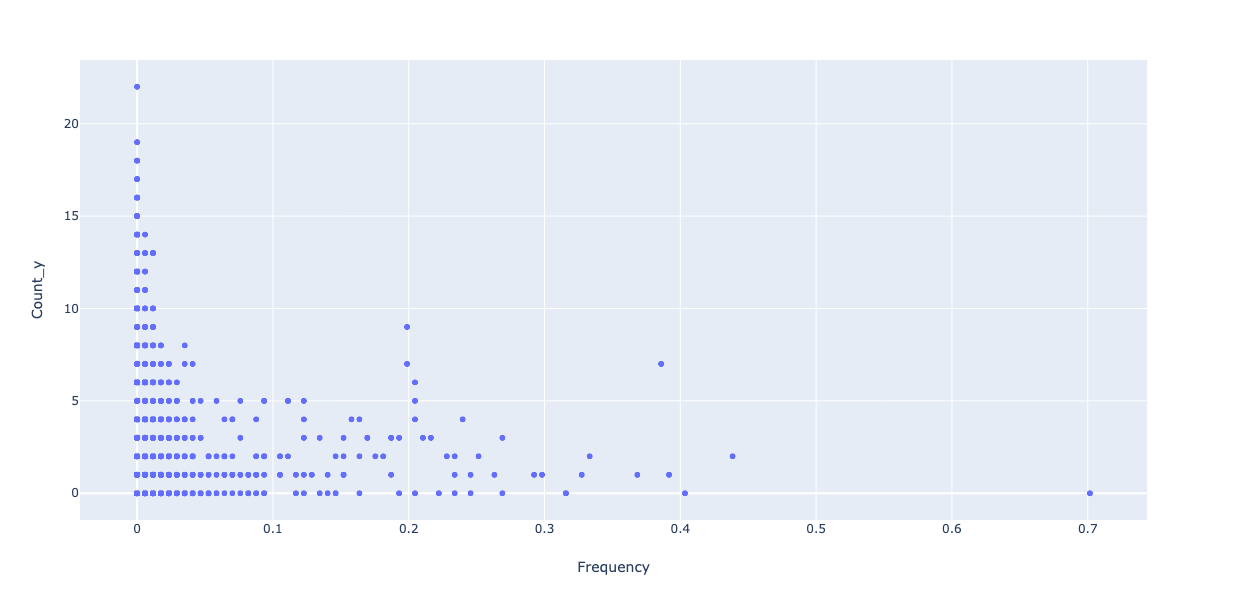

In [23]:
fig = px.scatter(datadfs['N01'], x='Frequency', y='Count_y')
fig.show()

In [34]:
total = pd.DataFrame()
total['CHROM'] = datadfs['N01'].CHROM
total['Window'] = datadfs['N01'].Window
total['Start'] = datadfs['N01'].Start
total['Stop'] = datadfs['N01'].Stop
total['Count_x'] = np.zeros(datadfs['N01'].shape[0])
total['N'] = np.zeros(datadfs['N01'].shape[0])
total['Frequency'] = np.zeros(datadfs['N01'].shape[0])
total['Count_y'] = datadfs['N01'].Count_y
for key in samples:
    total['Count_x'] = total.Count_x + datadfs[key].Count_x
    total['N'] = total.N + datadfs[key].N

In [35]:
total[0:10]

,CHROM,Window,Start,Stop,Count_x,N,Frequency,Count_y
0,chr01,0,0,100000,0.0,3044.0,0.0,4
1,chr01,1,100000,200000,4.0,3044.0,0.0,5
2,chr01,2,200000,300000,27.0,3044.0,0.0,2
3,chr01,3,300000,400000,17.0,3044.0,0.0,0
4,chr01,4,400000,500000,48.0,3044.0,0.0,1
5,chr01,5,500000,600000,38.0,3044.0,0.0,1
6,chr01,6,600000,700000,26.0,3044.0,0.0,4
7,chr01,7,700000,800000,2.0,3044.0,0.0,2
8,chr01,8,800000,900000,12.0,3044.0,0.0,7
9,chr01,9,900000,1000000,15.0,3044.0,0.0,3


In [36]:
total['Frequency'] = total.Count_x / total.N

In [37]:
total[0:10]

,CHROM,Window,Start,Stop,Count_x,N,Frequency,Count_y
0,chr01,0,0,100000,0.0,3044.0,0.000000,4
1,chr01,1,100000,200000,4.0,3044.0,0.001314,5
2,chr01,2,200000,300000,27.0,3044.0,0.008870,2
3,chr01,3,300000,400000,17.0,3044.0,0.005585,0
4,chr01,4,400000,500000,48.0,3044.0,0.015769,1
5,chr01,5,500000,600000,38.0,3044.0,0.012484,1
6,chr01,6,600000,700000,26.0,3044.0,0.008541,4
7,chr01,7,700000,800000,2.0,3044.0,0.000657,2
8,chr01,8,800000,900000,12.0,3044.0,0.003942,7
9,chr01,9,900000,1000000,15.0,3044.0,0.004928,3


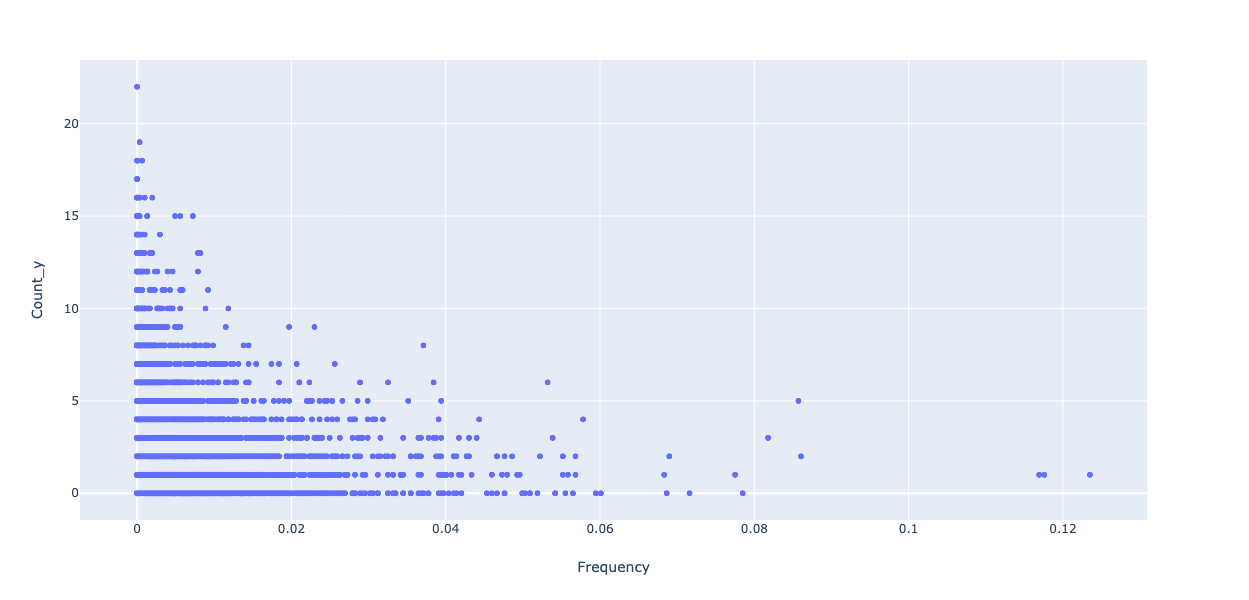

In [38]:
fig = px.scatter(total, x='Frequency', y='Count_y')
fig.show()

In [39]:
stats.pearsonr(total.Frequency, total.Count_y)

(-0.33820754283587057, 9.7040696542775e-101)

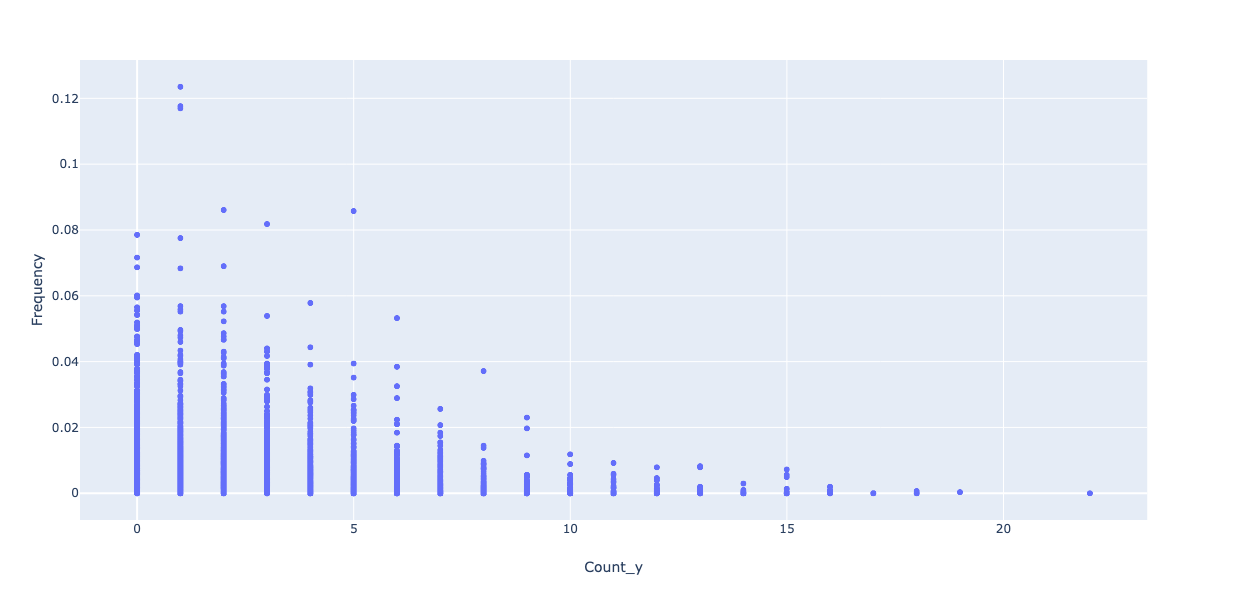

In [40]:
fig = px.scatter(total, x='Count_y', y='Frequency')
fig.show()

In [41]:
stats.pearsonr(total.Count_y, total.Frequency)

(-0.33820754283587057, 9.7040696542775e-101)

#### Class I TEs (retrotransposons) show a weak to moderate negative correlation to recombination frequency
Examination of class I TE density vs. recombination frequency indicates that there is a weak to moderate negative correlation $R^{2}=-0.33820754283587057,$ p-value$=9.7040696542775e^{-101})$. This is likely due to the fact that TEs are frequently targets of DNA methylation and heterochromatin is less accessible for the protein binding actions neccessary for the initiation of the DSBs that occur during meiotic recombination.

In [42]:
classII_densities = OrderedDict()
window_size = 100000
chroms = [''.join(['chr','{0:02d}'.format(n)]) for n in range(1, 13)]
classII['centroid'] = (classII.Start + classII.Stop) / 2
for key in samples:
    classII_densities[key] = OrderedDict()
    for c in chroms:
        classII_densities[key][c] = list()
        num_windows = (genome_size[c]//window_size) + 1
        for offset in range(0, num_windows):
            win_start = offset * window_size
            win_stop  = win_start + window_size
            count = sum((classII.centroid >= win_start) & (classII.centroid < win_stop) & (classII.CHROM == c))
            classII_densities[key][c].append([offset, win_start, win_stop, count])
        classII_densities[key][c] = pd.DataFrame(data=classII_densities[key][c],
                                                 columns=['Window', 'Start', 'Stop', 'Count'])

In [43]:
# Dump the recombination frequencies for all samples as tsv files
for key, fkey in zip(samples, founders):
    output_df = pd.DataFrame()
    for c in chroms:
        # Use of .copy() method here ensures we don't alter recombination_frequencies' dataframes
        rf_df = classII_densities[key][c].copy() 
        rf_df['CHROM'] = c
        rf_df = rf_df.reindex(columns=['CHROM', 'Window', 'Start', 'Stop', 'Count'])
        output_df = pd.concat([output_df, rf_df], axis=0)
    output_df.to_csv('recombination_frequency/{}_{}_classII_TEs.tsv'.format(key, fkey), sep='\t', index=False)

In [44]:
classII_densities = OrderedDict()
for key, fkey in zip(samples, founders):
    classII_densities[key] = pd.read_csv('recombination_frequency/{}_{}_classII_TEs.tsv'.format(key, fkey), sep='\t', index_col=None)

In [45]:
datadfs = OrderedDict()
for key in samples:
    datadfs[key] = pd.merge(recombination_frequencies[key], classII_densities[key], on=['CHROM','Window','Start','Stop'])

In [46]:
for key in samples:
    print('Sample {} ==> datadf: {} rows, recombination: {} rows, classII: {} rows'.format(key, datadfs[key].shape[0], 
                                                                                           recombination_frequencies[key].shape[0],
                                                                                           classII_densities[key].shape[0]))

Sample N01 ==> datadf: 3740 rows, recombination: 3740 rows, classII: 3740 rows
Sample N03 ==> datadf: 3740 rows, recombination: 3740 rows, classII: 3740 rows
Sample N04 ==> datadf: 3740 rows, recombination: 3740 rows, classII: 3740 rows
Sample N05 ==> datadf: 3740 rows, recombination: 3740 rows, classII: 3740 rows
Sample N06 ==> datadf: 3740 rows, recombination: 3740 rows, classII: 3740 rows
Sample N07 ==> datadf: 3740 rows, recombination: 3740 rows, classII: 3740 rows
Sample N08 ==> datadf: 3740 rows, recombination: 3740 rows, classII: 3740 rows
Sample N09 ==> datadf: 3740 rows, recombination: 3740 rows, classII: 3740 rows
Sample N10 ==> datadf: 3740 rows, recombination: 3740 rows, classII: 3740 rows
Sample N11 ==> datadf: 3740 rows, recombination: 3740 rows, classII: 3740 rows
Sample N12 ==> datadf: 3740 rows, recombination: 3740 rows, classII: 3740 rows
Sample N13 ==> datadf: 3740 rows, recombination: 3740 rows, classII: 3740 rows
Sample N14 ==> datadf: 3740 rows, recombination: 374

In [47]:
datadfs['N01'][0:10]

,CHROM,Window,Start,Stop,Count_x,N,Frequency,Count_y
0,chr01,0,0,100000,0,171,0.000000,0
1,chr01,1,100000,200000,0,171,0.000000,3
2,chr01,2,200000,300000,7,171,0.040936,3
3,chr01,3,300000,400000,0,171,0.000000,0
4,chr01,4,400000,500000,6,171,0.035088,2
5,chr01,5,500000,600000,2,171,0.011696,1
6,chr01,6,600000,700000,2,171,0.011696,1
7,chr01,7,700000,800000,1,171,0.005848,0
8,chr01,8,800000,900000,1,171,0.005848,0
9,chr01,9,900000,1000000,2,171,0.011696,0


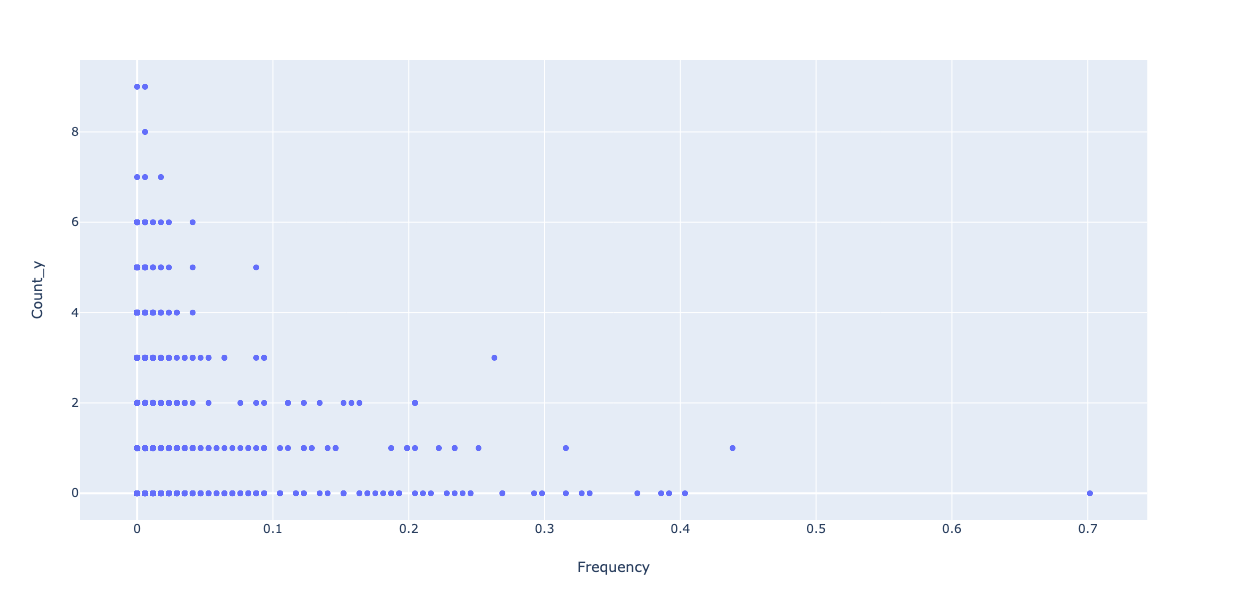

In [48]:
fig = px.scatter(datadfs['N01'], x='Frequency', y='Count_y')
fig.show()

In [49]:
classII_total = pd.DataFrame()
classII_total['CHROM'] = datadfs['N01'].CHROM
classII_total['Window'] = datadfs['N01'].Window
classII_total['Start'] = datadfs['N01'].Start
classII_total['Stop'] = datadfs['N01'].Stop
classII_total['Count_x'] = np.zeros(datadfs['N01'].shape[0])
classII_total['N'] = np.zeros(datadfs['N01'].shape[0])
classII_total['Frequency'] = np.zeros(datadfs['N01'].shape[0])
classII_total['Count_y'] = datadfs['N01'].Count_y
for key in samples:
    classII_total['Count_x'] = classII_total.Count_x + datadfs[key].Count_x
    classII_total['N'] = classII_total.N + datadfs[key].N

In [50]:
classII_total[0:10]

,CHROM,Window,Start,Stop,Count_x,N,Frequency,Count_y
0,chr01,0,0,100000,0.0,3044.0,0.0,0
1,chr01,1,100000,200000,4.0,3044.0,0.0,3
2,chr01,2,200000,300000,27.0,3044.0,0.0,3
3,chr01,3,300000,400000,17.0,3044.0,0.0,0
4,chr01,4,400000,500000,48.0,3044.0,0.0,2
5,chr01,5,500000,600000,38.0,3044.0,0.0,1
6,chr01,6,600000,700000,26.0,3044.0,0.0,1
7,chr01,7,700000,800000,2.0,3044.0,0.0,0
8,chr01,8,800000,900000,12.0,3044.0,0.0,0
9,chr01,9,900000,1000000,15.0,3044.0,0.0,0


In [51]:
classII_total['Frequency'] = classII_total.Count_x / classII_total.N

In [52]:
classII_total[0:10]

,CHROM,Window,Start,Stop,Count_x,N,Frequency,Count_y
0,chr01,0,0,100000,0.0,3044.0,0.000000,0
1,chr01,1,100000,200000,4.0,3044.0,0.001314,3
2,chr01,2,200000,300000,27.0,3044.0,0.008870,3
3,chr01,3,300000,400000,17.0,3044.0,0.005585,0
4,chr01,4,400000,500000,48.0,3044.0,0.015769,2
5,chr01,5,500000,600000,38.0,3044.0,0.012484,1
6,chr01,6,600000,700000,26.0,3044.0,0.008541,1
7,chr01,7,700000,800000,2.0,3044.0,0.000657,0
8,chr01,8,800000,900000,12.0,3044.0,0.003942,0
9,chr01,9,900000,1000000,15.0,3044.0,0.004928,0


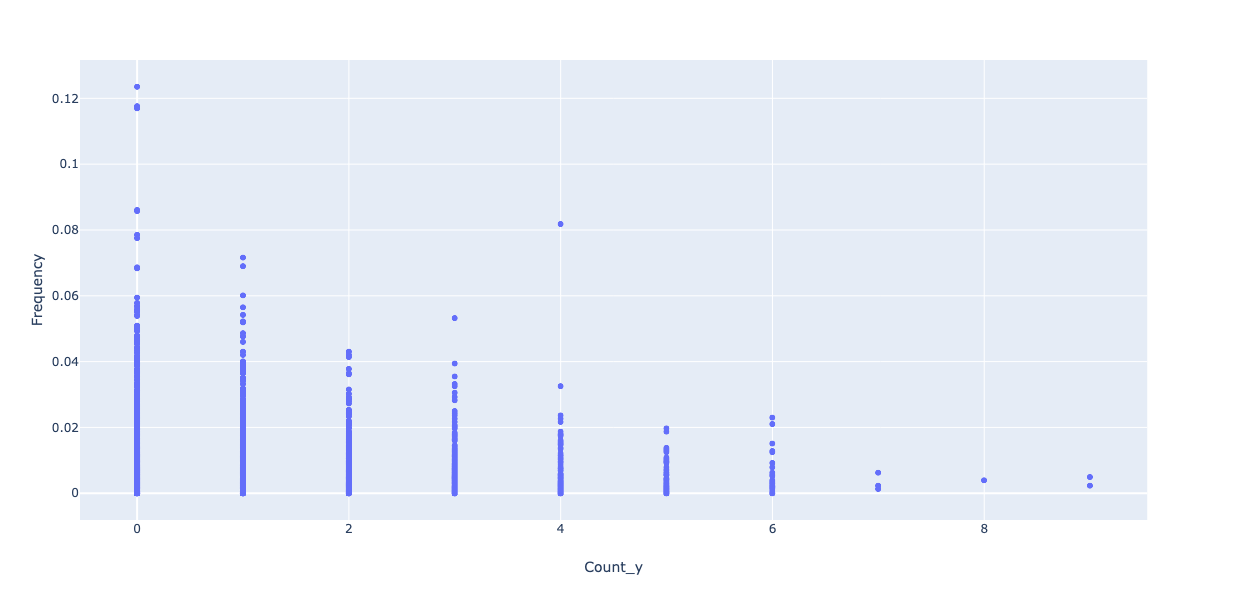

In [53]:
fig = px.scatter(classII_total, x='Count_y', y='Frequency')
fig.show()

In [54]:
stats.pearsonr(classII_total.Count_y, classII_total.Frequency)

(-0.13085918709951144, 9.38388790053868e-16)

In [55]:
np.mean(total.Frequency)

0.008537967211732287